In [3]:
# Ignorer les warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Charger les datasets d'entraînement et de test
import pandas as pd
train = pd.read_csv('train.csv', sep=",", index_col="Id")
test = pd.read_csv('test.csv', sep=",", index_col="Id")

In [5]:
train.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1237,160,RL,36.0,2628,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,175500
743,20,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,12,2007,WD,Normal,179000
747,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1088,60,FV,85.0,10574,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,252000
274,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,139000


In [6]:
train.shape

(1460, 80)

In [7]:
train.dtypes.value_counts()

object     43
int64      34
float64     3
Name: count, dtype: int64

In [8]:
# Vérifier la présence des variables manquantes
train.isna().sum().sum()

7829

In [9]:
valeurs_manquantes = train.isna().mean().round(4) * 100
valeurs_manquantes = valeurs_manquantes[valeurs_manquantes > 0].sort_values(ascending=False)
valeurs_manquantes

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
MasVnrType      59.73
FireplaceQu     47.26
LotFrontage     17.74
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
Electrical       0.07
dtype: float64

In [10]:
col_a_supprimer_1 = ["PoolQC", "MiscFeature", "Alley", "Fence", "MasVnrType"]

In [11]:
# Vérifier si le dataset contient des lignes ou valeurs dupliquées
train.duplicated().sum()

0

In [12]:
def supprimer_colonne(df : pd.DataFrame, cols : list):
    df = df.drop(columns=cols)
    return df

In [13]:
df = supprimer_colonne(train, col_a_supprimer_1)
df.shape

(1460, 75)

In [14]:
df_test = supprimer_colonne(test, col_a_supprimer_1)
df_test.shape

(1459, 74)

In [15]:
# Imputer les valeurs manquantes
from sklearn.impute import SimpleImputer

imputer_num = SimpleImputer(strategy="median")
imputer_cat = SimpleImputer(strategy="most_frequent")

def imputer_valeurs_manquantes(df: pd.DataFrame):
    '''Fonction qui prend en entrée un DataFtame et qui impute les colonnes
    numérique par la médiane et les colonnes catégorielles par le mode'''
    
    num_cols = [col for col in df.select_dtypes(include=["number"]).columns]
    cat_cols = [col for col in df.select_dtypes(include=["object"]).columns]
    
    if num_cols:
        df[num_cols] = imputer_num.fit_transform(df[num_cols])
    
    if cat_cols:
        df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
    return df


In [16]:
df = imputer_valeurs_manquantes(df)

# Vérifier la présence des variables manquantes
df.isna().sum().sum()

0

In [17]:
df_test = imputer_valeurs_manquantes(df_test)
df_test.isna().sum().sum()

0

In [18]:
# Sauvegarder le fichier imputer
df.to_csv('train_imputer.csv', index=False)

In [19]:
# Encoder les colonnes catégorielles

from sklearn.preprocessing import LabelEncoder 

def encoder_categorie(df: pd.DataFrame):
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        label_encoders[col] = encoder  # Sauvegarder l'encodeur pour chaque colonne
    return label_encoders

In [20]:
encoder = encoder_categorie(df)

In [21]:
encoder.items()

dict_items([('MSZoning', LabelEncoder()), ('Street', LabelEncoder()), ('LotShape', LabelEncoder()), ('LandContour', LabelEncoder()), ('Utilities', LabelEncoder()), ('LotConfig', LabelEncoder()), ('LandSlope', LabelEncoder()), ('Neighborhood', LabelEncoder()), ('Condition1', LabelEncoder()), ('Condition2', LabelEncoder()), ('BldgType', LabelEncoder()), ('HouseStyle', LabelEncoder()), ('RoofStyle', LabelEncoder()), ('RoofMatl', LabelEncoder()), ('Exterior1st', LabelEncoder()), ('Exterior2nd', LabelEncoder()), ('ExterQual', LabelEncoder()), ('ExterCond', LabelEncoder()), ('Foundation', LabelEncoder()), ('BsmtQual', LabelEncoder()), ('BsmtCond', LabelEncoder()), ('BsmtExposure', LabelEncoder()), ('BsmtFinType1', LabelEncoder()), ('BsmtFinType2', LabelEncoder()), ('Heating', LabelEncoder()), ('HeatingQC', LabelEncoder()), ('CentralAir', LabelEncoder()), ('Electrical', LabelEncoder()), ('KitchenQual', LabelEncoder()), ('Functional', LabelEncoder()), ('FireplaceQu', LabelEncoder()), ('GarageT

In [22]:
for col in df_test.select_dtypes(include=['object']).columns:
    if col in encoder:  # Assure-toi d'utiliser le même encodeur
        le = encoder[col]
        df_test[col] = le.transform(df_test[col])

In [23]:
# Définir fonction de sélection des colonnes à faible variance

def selectionner_colonnes_moins_variantes(df: pd.DataFrame, threshold_vari=0.8):
    ''' Fonction qui prend en entrée un DataFtame et qui sélectionne les colonnes moins variantes '''
    
    cols_select = []
    
    for col in df.columns:
        if (df[col].value_counts().max() / len(df[col])) > threshold_vari:
            cols_select.append(col)
    return cols_select

In [24]:
col_a_supprimer_2 = selectionner_colonnes_moins_variantes(df)
print(col_a_supprimer_2)

['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SaleType', 'SaleCondition']


In [25]:
df = supprimer_colonne(df,col_a_supprimer_2)
df.shape

(1460, 46)

In [26]:
df_test = supprimer_colonne(df_test,col_a_supprimer_2)
df_test.shape

(1459, 45)

In [27]:
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

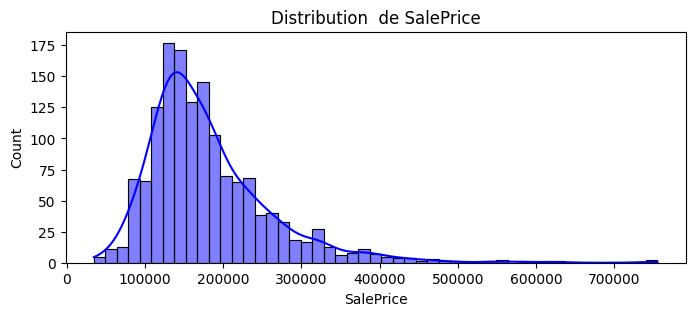

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [28]:
# Visualiser la distribution de SalePrice
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 3))
sns.histplot(y, kde=True, color='blue')
plt.title('Distribution  de SalePrice')
plt.show()

# Descriptive statistics of SalePrice
y.describe()

In [29]:
# Créer logarithme de SalePrice
import numpy as np
y_log = np.log1p(y)

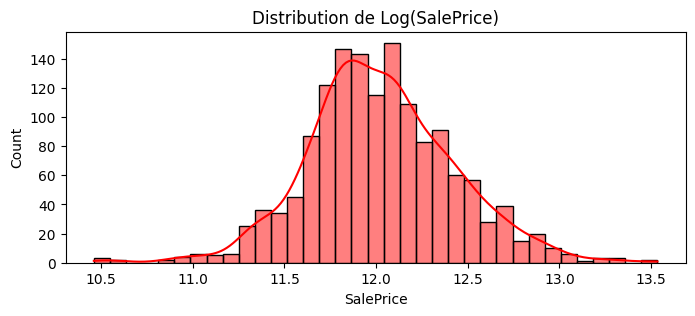

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

In [30]:
# Visualiser la distribution du logarithme de SalePrice
plt.figure(figsize=(8, 3))
sns.histplot(y_log, kde=True, color='red')
plt.title('Distribution de Log(SalePrice)')
plt.show()

# Descriptive statistics of SalePrice
y_log.describe()

In [31]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')

In [32]:
def creer_variable(df: pd.DataFrame):
    df["Log_GrLivArea"] = np.log1p(df["GrLivArea"])
    df["Log_TotalBsmtSF"] = np.log1p(df["TotalBsmtSF"])
    df["Log_1stFlrSF"] = np.log1p(df["1stFlrSF"])
    df["Log_LotArea"] = np.log1p(df["LotArea"])
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['SinceRemodel'] = df['YrSold'] - df['YearRemodAdd']
    df["TotalExterior"] = df["Exterior1st"] + df["Exterior2nd"]
    return df

In [33]:
X = creer_variable(X)

In [34]:
df_test = creer_variable(df_test)

In [35]:
col_a_supprimer_3 = ["GrLivArea", "TotalBsmtSF", "1stFlrSF", "LotArea", 'YearBuilt', 'YearRemodAdd', 'YrSold', "Exterior1st", "Exterior2nd"]
X = supprimer_colonne(X, col_a_supprimer_3)
df_test = supprimer_colonne(df_test, col_a_supprimer_3)

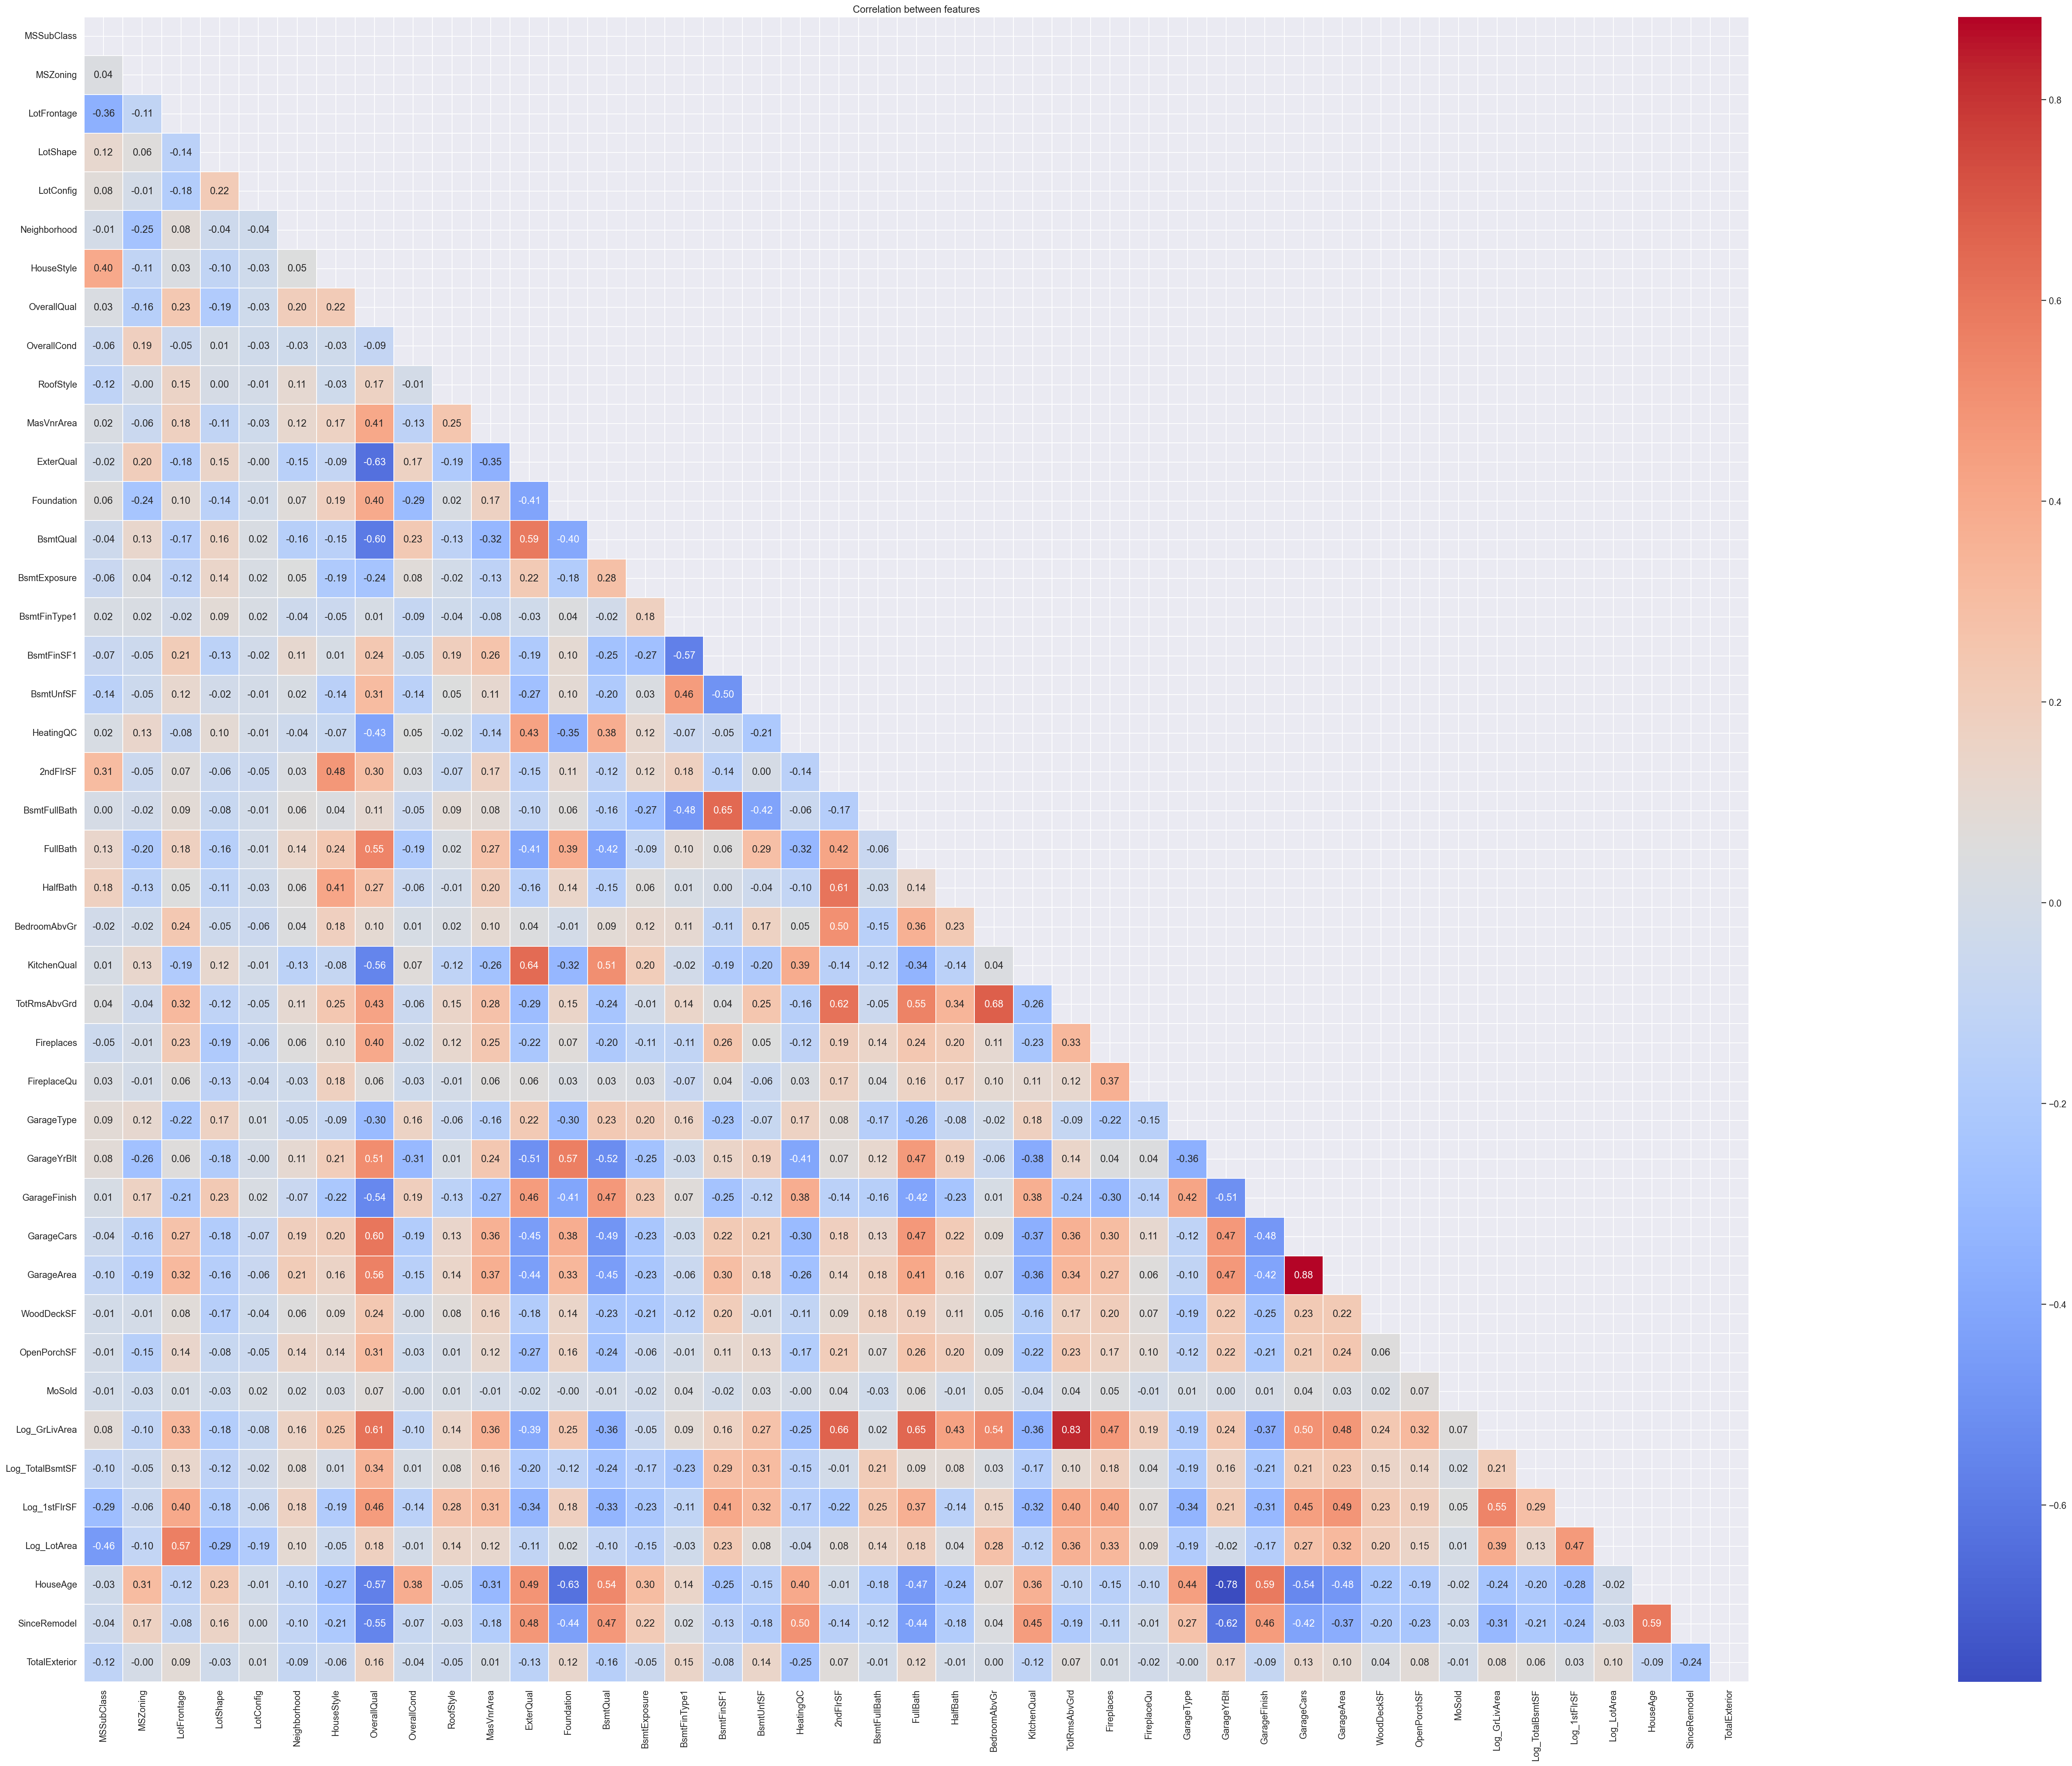

In [36]:
# Calcul de la matrice de corrélation
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Affichage de la heatmap
sns.set_theme(font_scale=1.1)
plt.figure(figsize=(100, 40), dpi=140)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap="coolwarm", square=True, mask=mask, linewidths=1, cbar=True)
plt.title('Correlation between features')
plt.show()

In [37]:
# Récupérer les paires de corrélations sous forme de DataFrame
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Retirer les paires avec une corrélation de 1 (c'est-à-dire une variable avec elle-même)
corr_pairs = corr_pairs[corr_pairs['Variable 1'] != corr_pairs['Variable 2']]

# Filtrer pour garder seulement les corrélations supérieures à 0.7 ou inférieures à -0.7
fort_corr = corr_pairs[abs(corr_pairs['Correlation']) > 0.75].drop_duplicates(subset=['Correlation'])

# Affichage des corrélations fortes
print("Forte Correlation (plus de 0.7 en valeur absolue):")
print(fort_corr)

Forte Correlation (plus de 0.7 en valeur absolue):
        Variable 1     Variable 2  Correlation
1111  TotRmsAbvGrd  Log_GrLivArea     0.825521
1287   GarageYrBlt       HouseAge    -0.776004
1365    GarageCars     GarageArea     0.882475


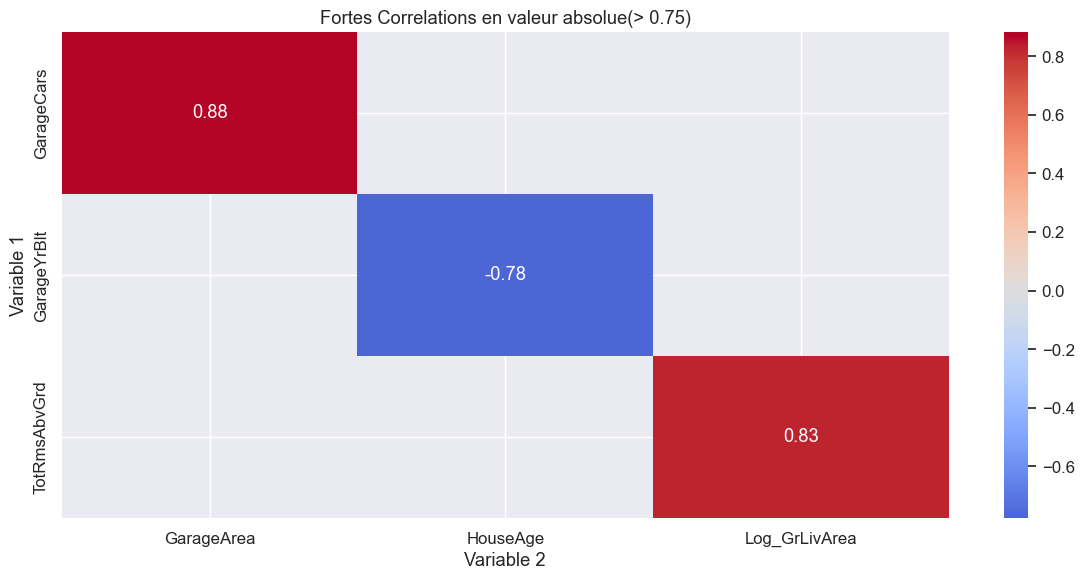

In [38]:
plt.figure(figsize=(12, 6))
sns.heatmap(fort_corr.pivot(index='Variable 1', columns='Variable 2', values='Correlation'),
             annot=True, cmap="coolwarm", center=0)
plt.title('Fortes Correlations en valeur absolue(> 0.75)')

plt.tight_layout()
plt.show()

In [39]:
col_a_supprimer_4 = ["GarageCars", "TotRmsAbvGrd", "GarageYrBlt"]
X = supprimer_colonne(X, col_a_supprimer_4)
X.shape

(1460, 40)

In [40]:
df_test = supprimer_colonne(df_test, col_a_supprimer_4)
df_test.shape

(1459, 40)

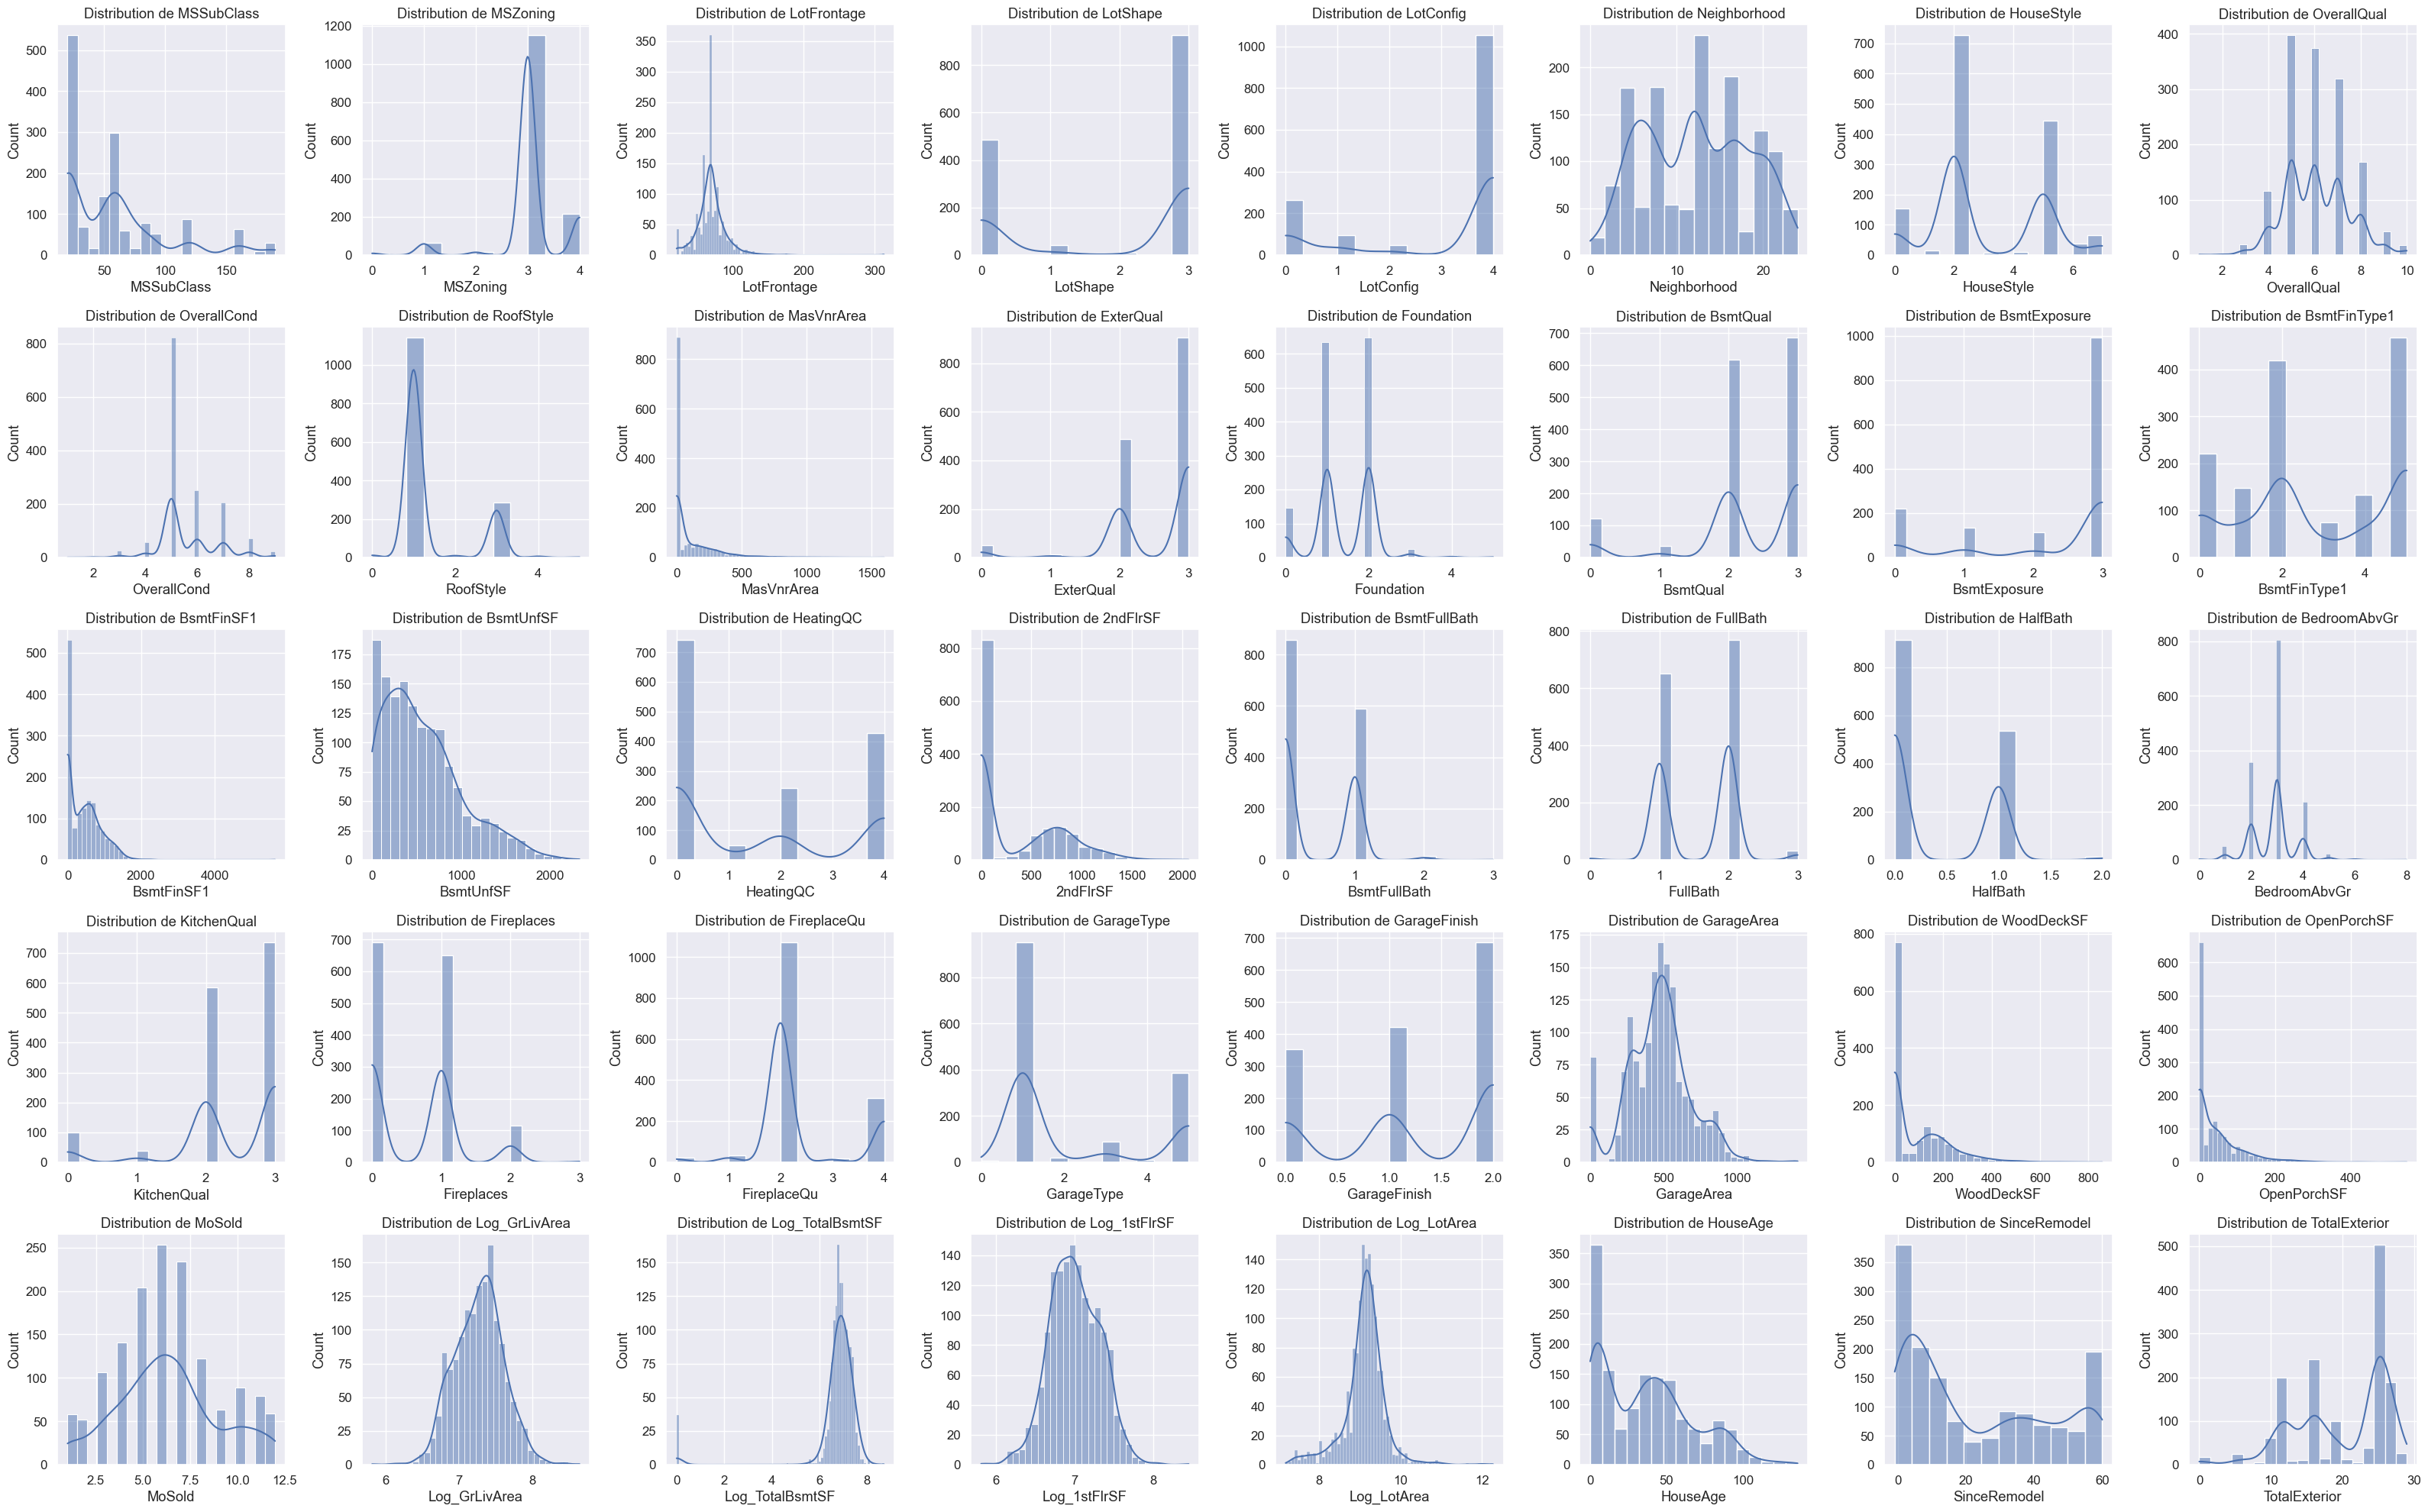

In [41]:
# Nombre de colonnes
nbr_cols = 8
num_features_count = len(X.columns)
nbr_rows = (num_features_count + nbr_cols - 1) // nbr_cols  # Calculate the number of lines needed

fig, axes = plt.subplots(nbr_rows, nbr_cols, figsize=(32, nbr_rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()


for i, feature in enumerate(X.columns):
    sns.histplot(X[feature], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution de {feature}")

# Delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [42]:
# Standardiser les données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_test_scaled = scaler.transform(df_test)

In [43]:
# Division en ensembles d'entraînement et de test (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)

In [44]:
# Modéliser
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Dictionnaires des modèles à tester
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor()
}

# Dictionnaire des hyperparamètres à optimiser pour chaque modèle
param_grids = {
    'Linear Regression': {},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.3, 0.5]},
    'XGBRegressor': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.3, 0.5]}
}


In [45]:
def evaluate_models(X_train, y_train, X_test, y_test, models, param_grids):
    results = {}
    
    for model_name, model in models.items():
        print(f"Optimisation et entraînement du modèle : {model_name}")
        
        # Si le modèle a des hyperparamètres à optimiser
        if param_grids[model_name]:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            print(f"Meilleurs hyperparamètres pour {model_name} : {grid_search.best_params_}")
        else:
            best_model = model
            best_model.fit(X_train, y_train)
        
        # Prédictions
        y_pred = best_model.predict(X_test)
        
        # Calcul des métriques
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[model_name] = {'MAPE': mape,'R²': r2}
        print(f"{model_name} -> MAPE: {mape:.4f}, R²: {r2:.4f}\n")
    
    return results

In [46]:
# Appeler la fonction pour comparer les modèles
results = evaluate_models(X_train, y_train, X_test, y_test, models, param_grids)

Optimisation et entraînement du modèle : Linear Regression
Linear Regression -> MAPE: 0.0084, R²: 0.8830

Optimisation et entraînement du modèle : Random Forest
Meilleurs hyperparamètres pour Random Forest : {'max_depth': 20, 'n_estimators': 200}
Random Forest -> MAPE: 0.0082, R²: 0.8824

Optimisation et entraînement du modèle : Gradient Boosting
Meilleurs hyperparamètres pour Gradient Boosting : {'learning_rate': 0.1, 'n_estimators': 200}
Gradient Boosting -> MAPE: 0.0076, R²: 0.9048

Optimisation et entraînement du modèle : XGBRegressor
Meilleurs hyperparamètres pour XGBRegressor : {'learning_rate': 0.1, 'n_estimators': 200}
XGBRegressor -> MAPE: 0.0079, R²: 0.8810



Résultats de la comparaison des modèles :
                       MAPE        R²
Gradient Boosting  0.007640  0.904798
XGBRegressor       0.007946  0.880970
Random Forest      0.008161  0.882447
Linear Regression  0.008366  0.882981


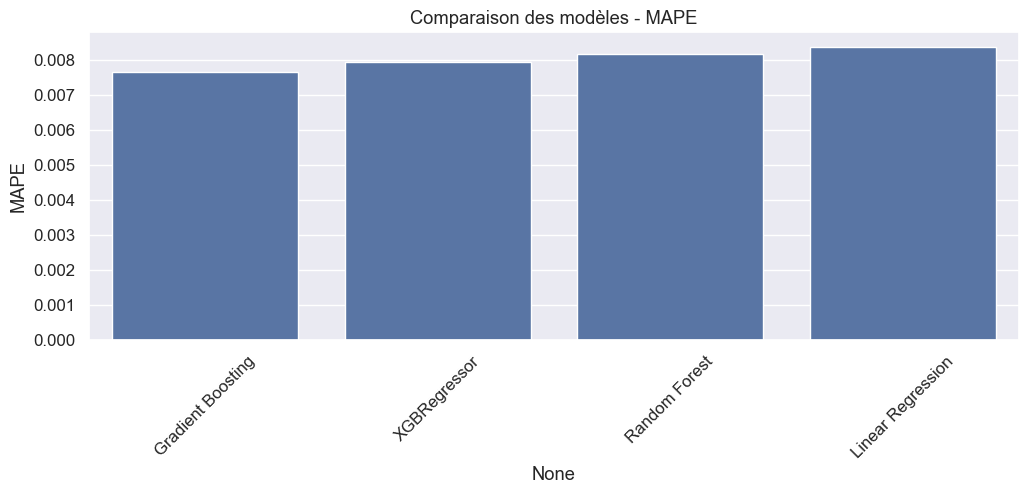

In [47]:
# Afficher les résultats
results_df = pd.DataFrame(results).T.sort_values(by="MAPE")
print("Résultats de la comparaison des modèles :")
print(results_df)

# Visualisation des résultats
plt.figure(figsize=(12, 4))
sns.barplot(x=results_df.index, y=results_df['MAPE'])
plt.xticks(rotation=45)
plt.title("Comparaison des modèles - MAPE")
plt.show()

In [48]:
# Trouver le meilleur modèle basé sur le RMSE
best_model_name = results_df['MAPE'].idxmin()
best_model_rmse = results_df['MAPE'].min()
best_model_r2 = results_df.loc[best_model_name, 'R²']

print(f"Le meilleur modèle est : {best_model_name}")
print(f"MAPE : {best_model_rmse:.4f}, R² : {best_model_r2:.4f}")

# Entraîner le modèle final avec les meilleurs hyperparamètres si applicable
final_model = models[best_model_name]
if param_grids[best_model_name]:
    grid_search = GridSearchCV(final_model, param_grids[best_model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    final_model = grid_search.best_estimator_
else:
    final_model.fit(X_train, y_train)

print("Le modèle final a été entraîné avec succès.")

Le meilleur modèle est : Gradient Boosting
MAPE : 0.0076, R² : 0.9048
Le modèle final a été entraîné avec succès.


In [49]:
# Predictions on the test set
test_final = df_test_scaled
test_predictions = final_model.predict(test_final)
final_predictions = np.expm1(test_predictions)

# Préparer la soumission
submission = pd.DataFrame({"Id" : test.index, "SalePrice" : final_predictions})

# Sauvegarder le fichier de soumission
submission.to_csv('submission.csv', index=False)
print("Soumission prête.")

submission.head(10)

Soumission prête.


,Id,SalePrice
0,1461,128482.884368
1,1462,155290.404407
2,1463,179855.637040
3,1464,187990.869818
4,1465,189123.116117
5,1466,182577.873113
6,1467,174888.702586
7,1468,168359.354881
8,1469,178520.432115
9,1470,121597.252883
